# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder (1 mark)

In [0]:
import os
import tensorflow as tf
#### Add your code here ####
project_dir = "/content/drive/My Drive/greatlakes/Projects/Advanced_Computer_Vision/Project1/"
os.chdir(project_dir)

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('images.npy', allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

In [70]:
#### Add your code here ####
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [73]:
X_train.shape

(409, 224, 224, 3)

In [74]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

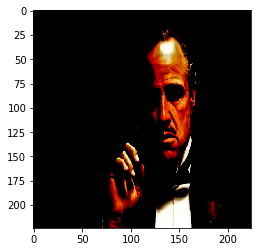

In [75]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

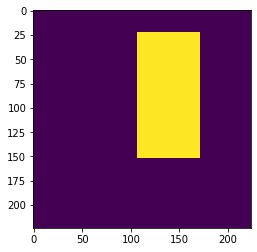

In [76]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

def create_model(trainable=True):
    model = model = MobileNet(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, alpha=ALPHA,weights="imagenet") # Load pre-trained mobilenet
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    
    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_WIDTH, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x) #### Add your code here ####

### Call the create_model function

In [78]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


### Dice Coefficient (F1 Score) Explanation
The Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images

In [0]:
def dice_coefficient(y_true, y_pred):
    #### Add your code here ####
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
#### Add your code here ####
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [82]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [83]:
#### Add your code here ####
EPOCHS = 10
BATCH_SIZE =1
model.fit(X_train, masks, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, callbacks=[checkpoint, reduce_lr, stop], workers=1,
                    use_multiprocessing=False)


Train on 409 samples
Epoch 1/10
408/409 [============================>.] - ETA: 0s - loss: 1.2902 - dice_coefficient: 0.4556
Epoch 00001: loss improved from inf to 1.29099, saving model to model-1.29.h5
409/409 [==============================] - 34s 84ms/sample - loss: 1.2910 - dice_coefficient: 0.4555
Epoch 2/10
408/409 [============================>.] - ETA: 0s - loss: 0.7735 - dice_coefficient: 0.6182
Epoch 00002: loss improved from 1.29099 to 0.77362, saving model to model-0.77.h5
409/409 [==============================] - 23s 57ms/sample - loss: 0.7736 - dice_coefficient: 0.6181
Epoch 3/10
408/409 [============================>.] - ETA: 0s - loss: 0.6429 - dice_coefficient: 0.6699
Epoch 00003: loss improved from 0.77362 to 0.64259, saving model to model-0.64.h5
409/409 [==============================] - 23s 57ms/sample - loss: 0.6426 - dice_coefficient: 0.6699
Epoch 4/10
408/409 [============================>.] - ETA: 0s - loss: 0.5626 - dice_coefficient: 0.7029
Epoch 00004: loss 

### Get the predicted mask for a sample image   (3 marks)

In [84]:
n = 10
sample_image = X_train[n]
#### Add your code here ####
print(sample_image.shape)
sample_image_reshaped = np.reshape(sample_image,(1,sample_image.shape[0],sample_image.shape[1],sample_image.shape[2]))
print(sample_image_reshaped.shape)
predicted_mask = model.predict(sample_image_reshaped)

(224, 224, 3)
(1, 224, 224, 3)


In [85]:
print(predicted_mask.shape)
print(masks[n].shape)
predicted_mask_reshaped = np.reshape(predicted_mask,masks[n].shape)
print(predicted_mask_reshaped.shape)

(1, 224, 224)
(224, 224)
(224, 224)


### Impose the mask on the image (3 marks)

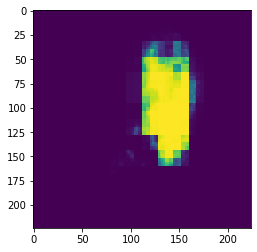

In [86]:
#### Add your code here ####
#pyplot.imshow(masks[n])
pyplot.imshow(predicted_mask_reshaped)

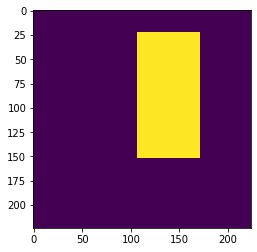

In [87]:
pyplot.imshow(masks[n])

## Actual Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


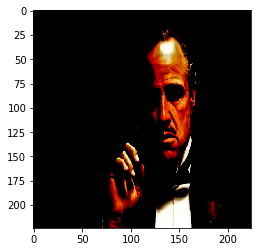

In [88]:
pyplot.imshow(sample_image)

## Masked Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


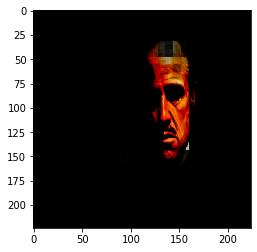

In [89]:
pred_mask = predicted_mask_reshaped

image2 = sample_image
image2[:,:,0] = pred_mask*sample_image[:,:,0]
image2[:,:,1] = pred_mask*sample_image[:,:,1]
image2[:,:,2] = pred_mask*sample_image[:,:,2]

out_image = image2

pyplot.imshow(out_image)
